### Call Option

In [10]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

S0 = 100              
K_values = [90, 100, 110] 
T = 1.0              
N = 50                
r = 0.05               
q = 0.07               
sigma = 0.2          
M = 10**5              
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level)/2) 

In [11]:
# Closed-form formula for geometric asian option
def geometric_asian_price(S0, K, r, q, sigma, T, N):
    sigma_geo = sigma * np.sqrt((N + 1)*(2*N + 1)/(6*N**2))
    mu_log_G = (r - q - 0.5*sigma**2) * (N + 1)/(2*N) * T
    var_log_G = sigma_geo**2 * T
    
    F = S0 * np.exp(mu_log_G + 0.5*var_log_G)
    d1 = (np.log(F/K) + 0.5*var_log_G) / (sigma_geo*np.sqrt(T))
    d2 = d1 - sigma_geo*np.sqrt(T)
    
    call_price = np.exp(-r*T) * (F*norm.cdf(d1) - K*norm.cdf(d2))
    return call_price

In [12]:
# Montecarlo
def simulate_asian_options(S0, K, r, q, sigma, T, N, M):
    np.random.seed(42)
    dt = T/N
    
    Z = np.random.normal(size=(M, N))
    increments = (r - q - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z
    exponents = np.cumsum(increments, axis=1)
    S_matrix = S0 * np.exp(exponents)
    
    arithmetic_avg = np.mean(S_matrix, axis=1)
    geometric_avg = np.exp(np.mean(np.log(S_matrix), axis=1))
    
    call_payoff_arith = np.maximum(arithmetic_avg - K, 0)
    call_payoff_geo = np.maximum(geometric_avg - K, 0)
    
    # Standard MC
    MC_price = np.exp(-r*T) * np.mean(call_payoff_arith)
    var_mc = np.var(call_payoff_arith)
    std_error_mc = np.sqrt(var_mc/M)
    MC_CI = (MC_price - z_score*std_error_mc, MC_price + z_score*std_error_mc)
    
    # Adjust Control
    geo_price = geometric_asian_price(S0, K, r, q, sigma, T, N)
    cov = np.cov(call_payoff_arith, call_payoff_geo)[0, 1]
    var_geo = np.var(call_payoff_geo)
    beta = cov / var_geo
    
    adjusted_payoff = call_payoff_arith - beta*(call_payoff_geo - geo_price)
    CV_price = np.exp(-r*T) * np.mean(adjusted_payoff)
    var_cv = np.var(adjusted_payoff)
    std_error_cv = np.sqrt(var_cv/M)
    CV_CI = (CV_price - z_score*std_error_cv, CV_price + z_score*std_error_cv)
    
    # Corr
    correlation = cov / (np.std(call_payoff_arith) * np.std(call_payoff_geo))
    
    return (
        MC_price, std_error_mc, MC_CI[0], MC_CI[1],
        CV_price, std_error_cv, CV_CI[0], CV_CI[1],
        var_mc / var_cv, correlation,
        call_payoff_arith, call_payoff_geo )

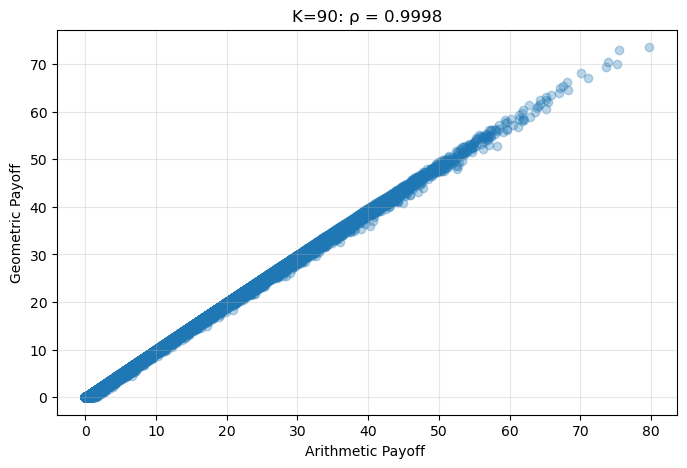

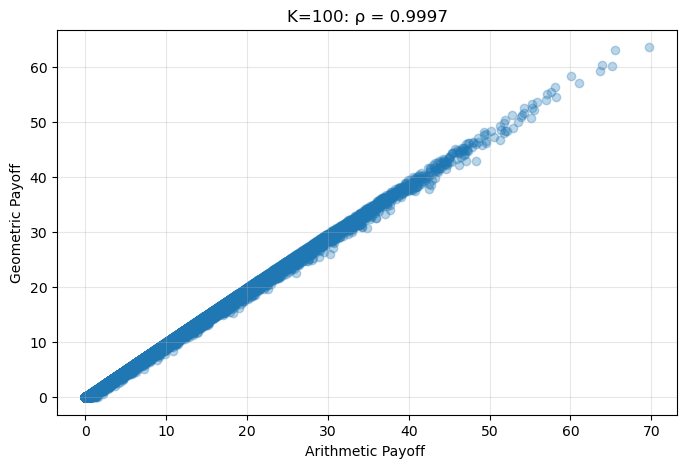

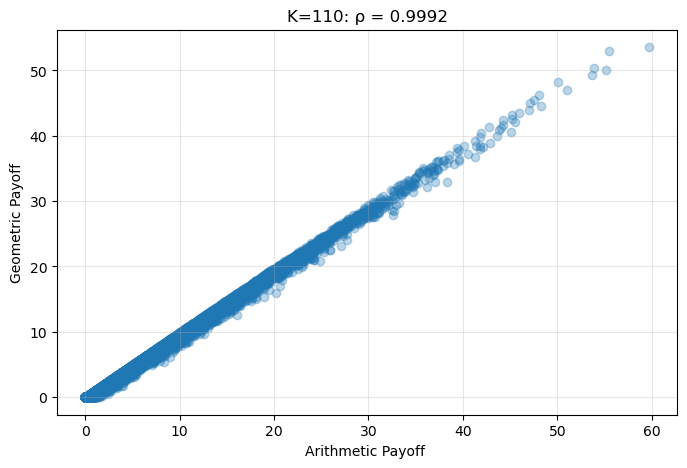

In [13]:
# Main programing
results = []
for K in K_values:
    output = simulate_asian_options(S0, K, r, q, sigma, T, N, M)
 
    (mc_price, mc_err, mc_ci_low, mc_ci_high, 
     cv_price, cv_err, cv_ci_low, cv_ci_high, 
     vrf, corr, 
     call_payoff_arith, call_payoff_geo) = output
  
    results.append({
        "K": K,
        "MC Price": mc_price,
        "MC Error": mc_err,
        "MC CI": f"[{mc_ci_low:.4f}, {mc_ci_high:.4f}]",
        "CV MC Price": cv_price,
        "CV MC Error": cv_err,
        "CV MC CI": f"[{cv_ci_low:.4f}, {cv_ci_high:.4f}]",
        "VRF": vrf,
        "Correlation": corr
    })
    
    # Plot Scatter
    plt.figure(figsize=(8, 5))
    plt.scatter(call_payoff_arith, call_payoff_geo, alpha=0.3)
    plt.xlabel("Arithmetic Payoff ")
    plt.ylabel("Geometric Payoff")
    plt.title(f"K={K}: ρ = {corr:.4f}")
    plt.grid(True, alpha=0.3)
    plt.show()


In [14]:
# Table
df = pd.DataFrame(results)
numeric_cols = ["MC Price", "MC Error", "CV MC Price", "CV MC Error", "VRF", "Correlation"]
df[numeric_cols] = df[numeric_cols].round(4)
df["VRF"] = df["VRF"].round(2)

print("\n========== The result of Asian Call Option Pricing==========")
print(df[["K", "MC Price", "MC Error", "MC CI", 
          "CV MC Price", "CV MC Error", "CV MC CI", 
          "VRF", "Correlation"]].to_string(index=False))


========== The result of Asian Call Option Pricing==========
  K  MC Price  MC Error            MC CI  CV MC Price  CV MC Error         CV MC CI     VRF  Correlation
 90    9.7221    0.0314 [9.6604, 9.7837]       9.2769       0.0007 [9.2755, 9.2783] 1980.36       0.9998
100    3.9223    0.0220 [3.8791, 3.9655]       3.7577       0.0006 [3.7566, 3.7589] 1477.06       0.9997
110    1.1731    0.0123 [1.1490, 1.1971]       1.1316       0.0005 [1.1307, 1.1326]  613.55       0.9992


 ### Conclusion
 The control variate method significantly reduces errors and improves estimation accuracy. When K=90, the MC error is 0.0314, while the CV MC error is only 0.0007, resulting in an approximately 45-fold reduction in error.  The variance reduction factor (VRF) falls within the range of 600-2000, demonstrating the high effectiveness of the control variate method in substantially reducing estimation variance. The control variate method produces more stable estimates than the MC method, with narrower confidence intervals and lower errors. For example, when K=90, the width of the MC confidence interval is 0.1233, whereas the CV MC confidence interval is only 0.0028, shrinking by approximately 44 times. The arithmetic average option price and geometric average option price are highly correlated, which explains the efficiency of the control variate method. The correlation coefficient ρ is close to 1 across all strike prices, further ensuring the successful application of the control variate technique.

### Put Option

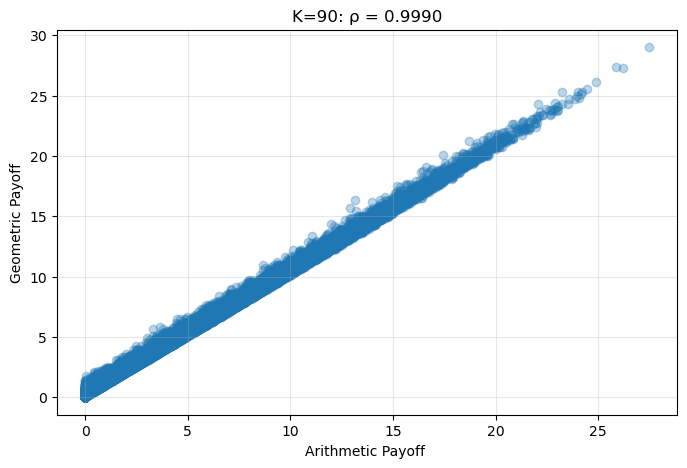

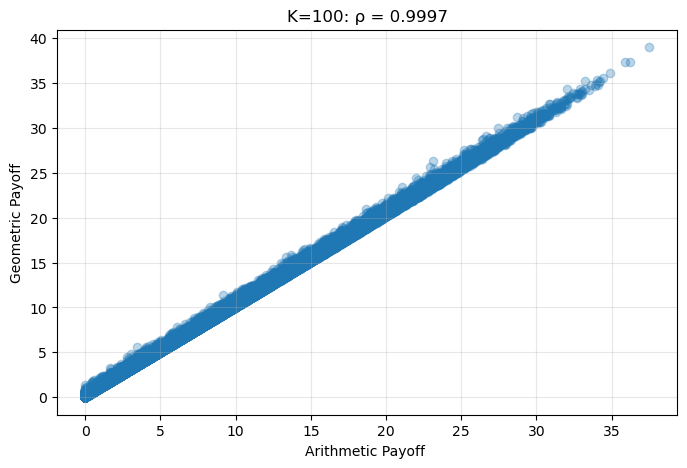

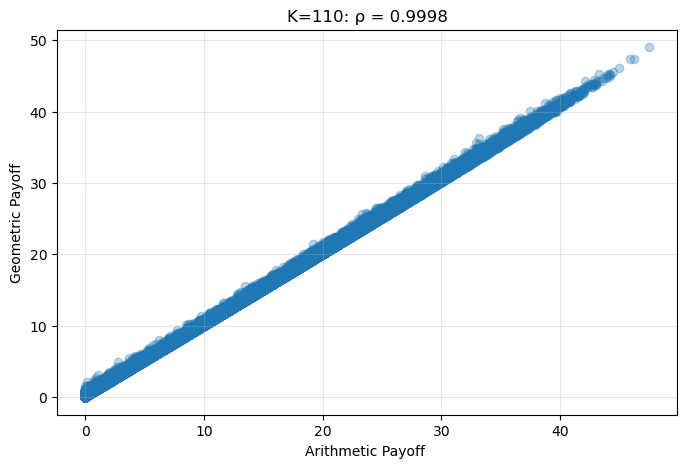

  K  MC Price  MC Error              MC CI  CV MC Price  CV MC Error           CV MC CI         VRF  Correlation
 90  1.186176  0.009846   [1.1669, 1.2055]     1.140991     0.000452   [1.1401, 1.1419]  474.950930     0.998957
100  4.898705  0.020735   [4.8581, 4.9393]     4.671416     0.000539   [4.6704, 4.6725] 1481.791792     0.999673
110 11.661740  0.029799 [11.6033, 11.7201]    11.092689     0.000644 [11.0914, 11.0940] 2143.619240     0.999777


In [15]:
# Closed-form formula for geometric Asian put option
def geometric_asian_put_price(S0, K, r, q, sigma, T, N):
    sigma_geo = sigma * np.sqrt((N + 1)*(2*N + 1)/(6*N**2))
    mu_log_G = (r - q - 0.5*sigma**2) * (N + 1)/(2*N) * T
    var_log_G = sigma_geo**2 * T
    
    F = S0 * np.exp(mu_log_G + 0.5*var_log_G)
    d1 = (np.log(F/K) + 0.5*var_log_G) / (sigma_geo*np.sqrt(T))
    d2 = d1 - sigma_geo*np.sqrt(T)
    
    put_price = np.exp(-r*T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    return put_price

# Monte Carlo simulation for Asian put options
def simulate_asian_put_options(S0, K, r, q, sigma, T, N, M):
    np.random.seed(42)
    dt = T/N
    
    Z = np.random.normal(size=(M, N))
    increments = (r - q - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z
    exponents = np.cumsum(increments, axis=1)
    S_matrix = S0 * np.exp(exponents)
    
    arithmetic_avg = np.mean(S_matrix, axis=1)
    geometric_avg = np.exp(np.mean(np.log(S_matrix), axis=1))
    
    put_payoff_arith = np.maximum(K - arithmetic_avg, 0)
    put_payoff_geo = np.maximum(K - geometric_avg, 0)
    
    # Standard Monte Carlo
    MC_price = np.exp(-r*T) * np.mean(put_payoff_arith)
    var_mc = np.var(put_payoff_arith)
    std_error_mc = np.sqrt(var_mc/M)
    MC_CI = (MC_price - z_score*std_error_mc, MC_price + z_score*std_error_mc)
    
    # Control Variate Method
    geo_price = geometric_asian_put_price(S0, K, r, q, sigma, T, N)
    cov = np.cov(put_payoff_arith, put_payoff_geo)[0, 1]
    var_geo = np.var(put_payoff_geo)
    beta = cov / var_geo
    
    adjusted_payoff = put_payoff_arith - beta * (put_payoff_geo - geo_price)
    CV_price = np.exp(-r*T) * np.mean(adjusted_payoff)
    var_cv = np.var(adjusted_payoff)
    std_error_cv = np.sqrt(var_cv/M)
    CV_CI = (CV_price - z_score*std_error_cv, CV_price + z_score*std_error_cv)
    
    # Correlation
    correlation = cov / (np.std(put_payoff_arith) * np.std(put_payoff_geo))
    
    return (
        MC_price, std_error_mc, MC_CI[0], MC_CI[1],
        CV_price, std_error_cv, CV_CI[0], CV_CI[1],
        var_mc / var_cv, correlation,
        put_payoff_arith, put_payoff_geo )

# Main program
results = []
for K in K_values:
    output = simulate_asian_put_options(S0, K, r, q, sigma, T, N, M)
    
    (mc_price, mc_err, mc_ci_low, mc_ci_high, 
     cv_price, cv_err, cv_ci_low, cv_ci_high, 
     vrf, corr, 
     put_payoff_arith, put_payoff_geo) = output
  
    results.append({
        "K": K,
        "MC Price": mc_price,
        "MC Error": mc_err,
        "MC CI": f"[{mc_ci_low:.4f}, {mc_ci_high:.4f}]",
        "CV MC Price": cv_price,
        "CV MC Error": cv_err,
        "CV MC CI": f"[{cv_ci_low:.4f}, {cv_ci_high:.4f}]",
        "VRF": vrf,
        "Correlation": corr
    })
    
    # Plot Scatter
    plt.figure(figsize=(8, 5))
    plt.scatter(put_payoff_arith, put_payoff_geo, alpha=0.3)
    plt.xlabel("Arithmetic Payoff ")
    plt.ylabel("Geometric Payoff")
    plt.title(f"K={K}: ρ = {corr:.4f}")
    plt.grid(True, alpha=0.3)
    plt.show()

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


# Conclusion
For Put option, the control variate method significantly reduces errors, improving estimation accuracy. For K=100, the MC error is 0.0207, while the CV MC error is only 0.0005, a 41-fold reduction. The variance reduction factor (VRF) ranges from 475 to 2144, with K=110 reaching 2144, indicating a massive variance reduction. CV MC estimates are more stable, with confidence intervals 20-40 times narrower, enhancing precision. The high correlation (ρ≈0.999) between arithmetic and geometric average prices ensures the control variate method's effectiveness.